# Generative Adverserial Networks

Deep neural networks are used mainly for supervised learning: classification or regression. Generative Adverserial Networks or GANs, however, use neural networks for a very different purpose: Generative modeling

While there are many approaches used for generative modeling, a Generative Adverserial Network takes the following approach: 

![GAN Flowchart](https://i.imgur.com/6NMdO9u.png)

## 0.Libraries

In [49]:
import numpy as np
import pandas as pd
import os
import zipfile
import cv2 as cv
import matplotlib.pyplot as plt
import time
from IPython.display import Image

In [50]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

## 1.Image Loader and Transforms

In [51]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [52]:
train_ds = ImageFolder(IMG_DIR, transform = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 3, pin_memory = True)

In [53]:
train_ds

Dataset ImageFolder
    Number of datapoints: 63565
    Root location: ../input/animefacedataset
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(64, 64))
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

## 2.Show a batch of images

In [54]:
import torch
from torchvision.utils import make_grid

In [55]:
# denormalize
def denormalize(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

# to show the images
def show_images(images, n_max = 64):
    fig, ax = plt.subplots(figsize = (12,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denormalize(images.detach()[:n_max]), nrow = 8).permute(1,2,0))
    
def show_batch(dl, n_max = 64):
    for images, _ in dl:
        show_images(images,n_max)
        break

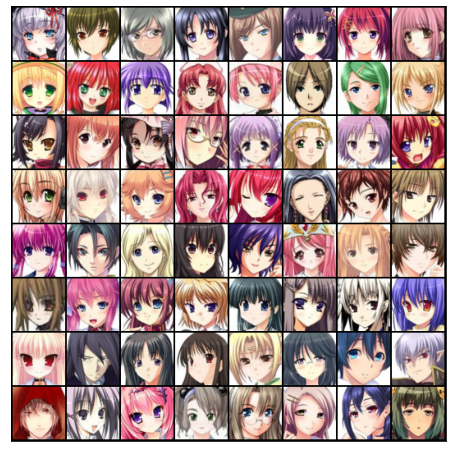

In [56]:
show_batch(train_dl)

## 3.Using a GPU

In [57]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [58]:
device = get_default_device()
device

device(type='cuda')

In [59]:
train_dl = DeviceDataLoader(train_dl,device)

## 4.Discriminator Network

### Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [60]:
import torch.nn as nn
import torch.nn.functional as F

In [61]:
discriminator = nn.Sequential(
    # in 3*64*64
    nn.Conv2d(3,64, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out 64*32*32
    
    nn.Conv2d(64,128, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out 128*16*16
    
    nn.Conv2d(128,256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out 256*8*8
    
    nn.Conv2d(256,512, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out 512*4*4
    
    nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
    # 1*1*1
    
    nn.Flatten(),
    nn.Sigmoid()
)

discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [62]:
discriminator = to_device(discriminator, device)

## 5.Generator Network

### Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [63]:
latent_size = 128

generator = nn.Sequential(
    # in latent_size*1*1
    nn.ConvTranspose2d(latent_size, 512, kernel_size = 4, stride = 1, padding = 0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512*4*4
    
    nn.ConvTranspose2d(512, 256, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256*8*8
    
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

torch.Size([128, 3, 64, 64])


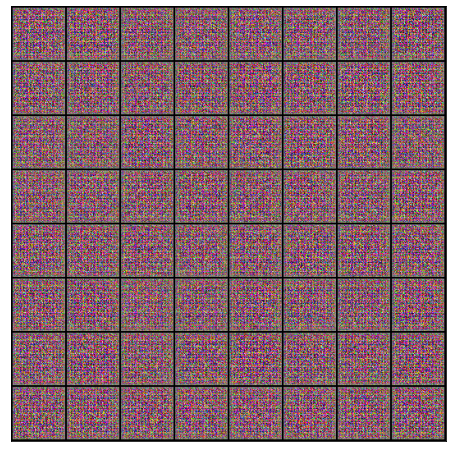

In [64]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [65]:
generator = to_device(generator,device)

## 6.Discriminator Training

In [66]:
def train_discriminator(real_images, opt_d):
    # clear discrimimnator gradients
    opt_d.zero_grad()
    
    # pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device = device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # passing fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds,fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    # update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    
    return loss.item(), real_score, fake_score

## 7.Generator Training

In [67]:
def train_generator(opt_g):
    # clear generator gradients
    opt_g.zero_grad()
    
    # generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
    fake_images = generator(latent)
    
    # try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device = device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

- **Let's create a directory to store generated images.**

In [68]:
!mkdir Generated
sample_dir = "./Generated"

mkdir: cannot create directory ‘Generated’: File exists


In [69]:
from torchvision.utils import save_image

In [70]:
def save_samples(index, latent_tensors, show = True):
    fake_images = generator(latent_tensors)
    fake_fname = "gen-image-{0:0=4d}.jpg".format(index)
    save_image(denormalize(fake_images), os.path.join(sample_dir, fake_fname), nrow = 8)
    print('Saving .. ', fake_fname)
    
    if show:
        fig,ax = plt.subplots(figsize = (8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow = 8).permute(1,2,0))

In [71]:
fixed_latent = torch.randn(64, latent_size, 1,1, device = device)

Saving ..  gen-image-0000.jpg


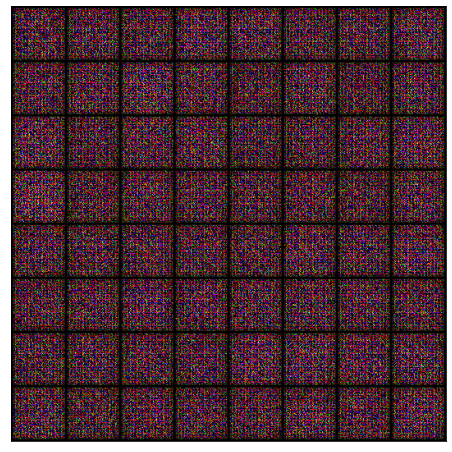

In [72]:
save_samples(0,fixed_latent)

## 8.Full Training Loop



<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [73]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [74]:
def fit(epochs, lr, start_index = 1):
    torch.cuda.empty_cache()
    
    # losses and scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr, betas = (0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr = lr, betas = (0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            
            # train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # train generator
            loss_g = train_generator(opt_g)
            
        # record losses and scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # log losses and score (last batch)
        print(f"Epoch [{epoch+1}/{epochs}], loss_g : {loss_g:.4f}, loss_d : {loss_d:.4f}, real_score : {real_score:.4f}, fake_score : {fake_score:.4f}")
        
        # save generated images
        save_samples(epoch+start_index, fixed_latent, show = False)
        
    return losses_g, losses_d, real_scores, fake_scores

### **Train the model.**

In [75]:
lr = 0.0002
epochs = 25

In [76]:
start = time.time()

history = fit(epochs, lr)

end = time.time()

print(f"Finished in {(end-start):.4f} seconds.")

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g : 2.8271, loss_d : 0.8541, real_score : 0.5743, fake_score : 0.1149
Saving ..  gen-image-0001.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g : 4.0302, loss_d : 0.7333, real_score : 0.5872, fake_score : 0.0222
Saving ..  gen-image-0002.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g : 10.0011, loss_d : 0.8302, real_score : 0.9275, fake_score : 0.4825
Saving ..  gen-image-0003.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g : 6.3021, loss_d : 0.1089, real_score : 0.9328, fake_score : 0.0294
Saving ..  gen-image-0004.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g : 3.5010, loss_d : 0.3163, real_score : 0.7946, fake_score : 0.0327
Saving ..  gen-image-0005.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g : 6.1641, loss_d : 0.2565, real_score : 0.8198, fake_score : 0.0128
Saving ..  gen-image-0006.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g : 10.6465, loss_d : 0.6974, real_score : 0.9949, fake_score : 0.4328
Saving ..  gen-image-0007.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g : 5.6226, loss_d : 0.4326, real_score : 0.7320, fake_score : 0.0024
Saving ..  gen-image-0008.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g : 0.7655, loss_d : 0.7385, real_score : 0.5803, fake_score : 0.0228
Saving ..  gen-image-0009.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g : 7.0299, loss_d : 0.1376, real_score : 0.8906, fake_score : 0.0105
Saving ..  gen-image-0010.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g : 5.0422, loss_d : 0.2285, real_score : 0.8395, fake_score : 0.0034
Saving ..  gen-image-0011.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g : 0.3035, loss_d : 1.0619, real_score : 0.4382, fake_score : 0.0039
Saving ..  gen-image-0012.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g : 5.4430, loss_d : 0.3594, real_score : 0.9925, fake_score : 0.2500
Saving ..  gen-image-0013.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g : 5.9278, loss_d : 0.2852, real_score : 0.9823, fake_score : 0.2138
Saving ..  gen-image-0014.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g : 4.0793, loss_d : 0.1210, real_score : 0.9448, fake_score : 0.0562
Saving ..  gen-image-0015.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g : 4.2309, loss_d : 0.1022, real_score : 0.9386, fake_score : 0.0325
Saving ..  gen-image-0016.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g : 3.5262, loss_d : 0.1532, real_score : 0.8908, fake_score : 0.0264
Saving ..  gen-image-0017.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g : 4.4786, loss_d : 0.1385, real_score : 0.9598, fake_score : 0.0795
Saving ..  gen-image-0018.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g : 3.4740, loss_d : 0.1642, real_score : 0.8736, fake_score : 0.0169
Saving ..  gen-image-0019.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g : 3.4865, loss_d : 0.3138, real_score : 0.7946, fake_score : 0.0375
Saving ..  gen-image-0020.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g : 4.7188, loss_d : 0.6135, real_score : 0.9834, fake_score : 0.3674
Saving ..  gen-image-0021.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g : 3.1449, loss_d : 0.3481, real_score : 0.7603, fake_score : 0.0107
Saving ..  gen-image-0022.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g : 3.2145, loss_d : 0.1236, real_score : 0.9116, fake_score : 0.0220
Saving ..  gen-image-0023.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g : 4.1974, loss_d : 0.1863, real_score : 0.9912, fake_score : 0.1396
Saving ..  gen-image-0024.jpg


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g : 2.0900, loss_d : 0.2185, real_score : 0.8372, fake_score : 0.0157
Saving ..  gen-image-0025.jpg
Finished in 4357.9893 seconds.


In [86]:
losses_g, losses_d, real_scores, fake_scores = history

In [87]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

## 9.Result Visualizations

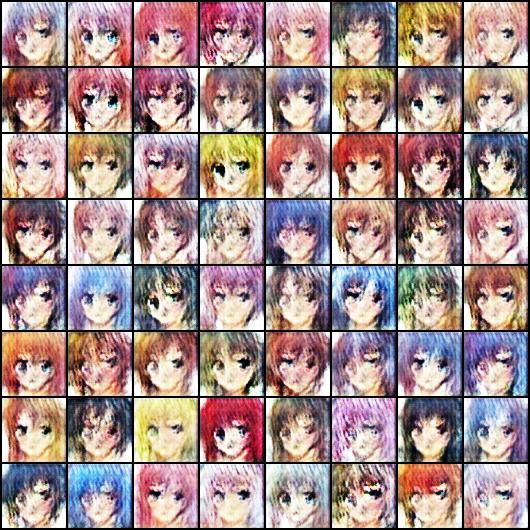

In [88]:
# Image 2
Image("./Generated/gen-image-0002.jpg")

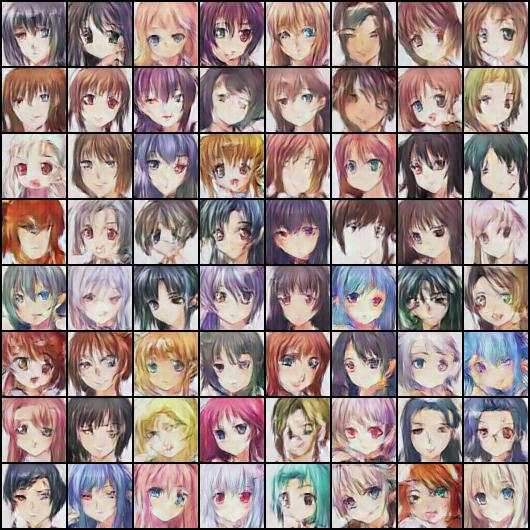

In [89]:
# Image 8
Image("./Generated/gen-image-0015.jpg")

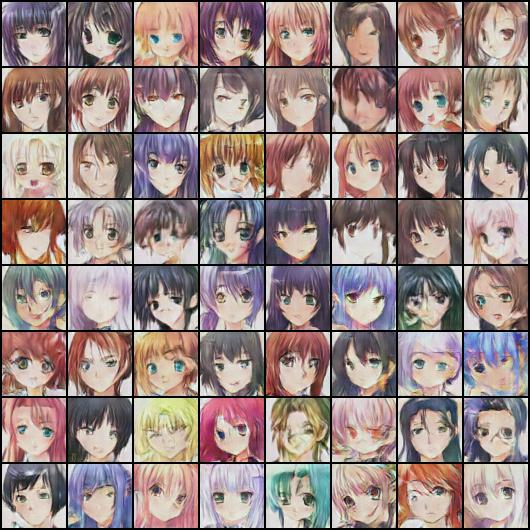

In [90]:
# Image 20
Image("./Generated/gen-image-0020.jpg")

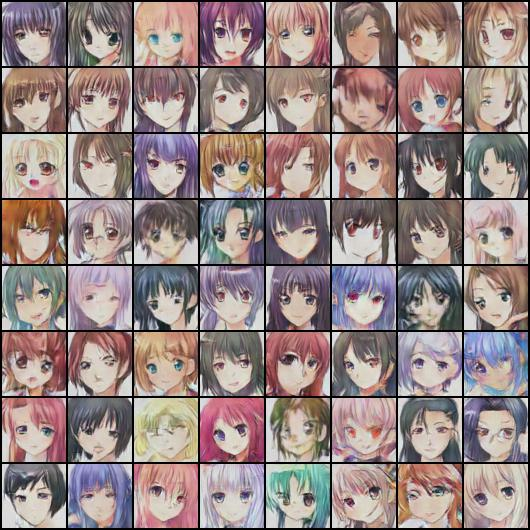

In [91]:
# Image 25
Image("./Generated/gen-image-0025.jpg")


In [92]:
# saving the progress to a video

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'gen' in f]
files.sort()

out = cv.VideoWriter(vid_fname,cv.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv.imread(fname)) for fname in files]
out.release()

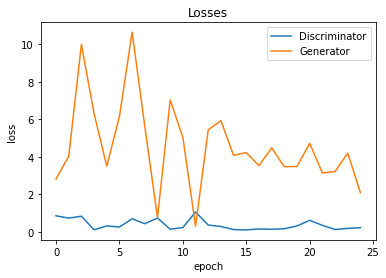

In [93]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

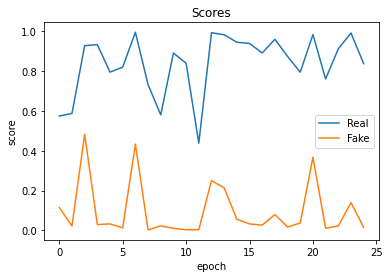

In [94]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

### References
- Gif at https://www.kaggle.com/anshalsingh/gif-gan-anime-face-dataste?select=improvement.gif
- https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans